In [1]:
import ml_eke
from importlib import reload
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
reload(ml_eke)

<module 'ml_eke' from '/lus/snx11254/ashao/dev/machine_learning_eke/ml_eke/__init__.py'>

# Background
Eddy effects like the transfer of momentum, drawdown of available potential energy, enhanced mixing of tracers, must be parameterized in coarse-resolution ocean simulations. The Boussinesq hypothesis suggests that unresolved eddy terms can be modeled as a diffusive term, the strength of which is represented by an eddy viscosity for momentum or an eddy diffusivity for tracers. Additionally, Gent and McWilliams [1990] proposed a parameterization of the overturning circulation arising from mesoscale eddies, drawing down available potential energy (resulting from horizontal buoyancy gradients). The strength of this parameterizing now tends to be referred to as the Gent-McWilliams diffusivity or thickness diffusivity.

Setting a value for these diffusivities and viscosities, consistent with the state of the ocean model, is a core challenge in ocean modelling. Ideally, a parameterization should be scale aware so that eddy parameterizations are not applied when eddies are resolved and the strength of the parameterization varies realistically based on the resolved physics. Jansen et al. [2015] use an estimate of an eddy length scale with an eddy kinetic energy (EKE) to derive a diffusivity. A prognostic equation governing the grid EKE describes sources of energy (the resolved circulation, a constant background source), sinks of energy (like dissipation due to topographic drag), and a diffusion of energy. However, this equation contains a variety of free parameters that must be specified. The form of this equation is also somewhat ad hoc and does not necessarily follow from first principles.

This project proposes to use a machine-learning (ML) model to replace the prognostic EKE equation in the Jansen et al. [2015] based Mesoscale Eddy Kinetic Energy (MEKE) parameterization. While a ML model is even more ad hoc, it also has the potential to provide more accurate predictions given sufficient training data.

# Proposed methodology
## Primary goals
1. Use output from an eddy-resolving simulation using the Parallel Ocean Program to calculate eddy kinetic energy directly as well as various, rotationally-invariant quantities that may relate to EKE
2. Train and evaluate various ML architectures for skillful prediction of EKE
3. Use this trained model to perform online inference using data streamed out of MOM6.
4. The predicted EKE is then streamed back into MOM6 and a GM diffusivity calculated using the MEKE
5. Evaluate improvements in model skill using the original MEKE parameterization versus the ML-enhanced parameterization.

## Secondary goals
1. Use feature selection for physical insight into how the predictor quantities affect EKE
2. Apply some form of unsupervised classification to understand different dynamic regimes in the ocean.

## Predictor quantities
Note that many of these quantities are calculated layer-by-layer and then vertically averaged. Additionally, some are also squared to ensure these quantities are rotationally-invariant (i.e. not sensitive to clockwise or anti-clockwise eddies). 

- Wind Stress: transfer of momentum between the atmosphere and ocean
- Relative vorticity (vertically averaged, squared)
- Divergence (vertically averaged, squared)
- Deformation rate (vertically averaged, squared)
- Mean Kinetic Energy (vertically averaged): Kinetic energy of the circulation resolved in the model
- Isopycnal slope (vertically averaged): Horizontal gradient in density
- Prandtl number (vertically averaged): Ratio of momentum to scalar diffusivity
- Absolute momentum slope: vertical average: Horizontal gradient of the momentum equations

# Notebook goals
- Show how to load and manipulate pre-processed POP output
- Understand which 

In [2]:
datapath = '/home/users/ashao/snx11254/data/ncar/eke_param'
model_data = ml_eke.pop_data(f'{datapath}/INPUT_DATA',f'{datapath}/TRAINING_DATA')

In [3]:
print('Available predictor variables (number of files):')
for key in model_data.predictor_inventory.keys():
    nfiles = len(model_data.predictor_inventory[key]['files'])
    print(f'\t{key}:{nfiles}')
print('Available predictand variables (number of files):')
for key in model_data.predictand_inventory.keys():
    nfiles = len(model_data.predictand_inventory[key]['files'])
    print(f'\t{key}:{nfiles}')


Available predictor variables (number of files):
	wind_stress:290
	relvort2_vert_avg:290
	div2_vert_avg:290
	def_rate2_vert_avg:290
	MKE_vert_avg:290
	isopycnal_slope_vert_avg:290
	prandtl_ratio_vert_avg:290
	absolute_momentum_slope_vert_avg:290
Available predictand variables (number of files):
	TKE_vert_avg:290
	MKE_vert_avg:290
	EKE_vert_avg:290
	TKE_sfc:290
	MKE_sfc:290
	EKE_sfc:290


In [9]:
out = model_data.extract_2d_var('EKE_vert_avg',0)

/home/users/ashao/snx11254/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


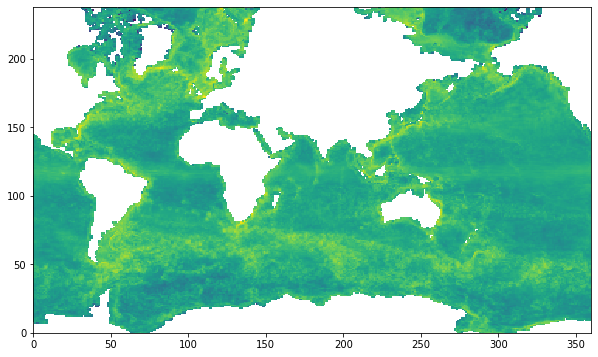

In [13]:
plt.figure(figsize=(10,6))
plt.pcolormesh(np.log10(out))

Figure: Log_10, vertically averaged kinetic energy. Note spatial heterogeneity with enhanced EKE near boundary currents and in the Southern Ocean

In [6]:
X, Y = model_data.extract_sample_from_time(model_data.predictor_inventory.keys(),['EKE_vert_avg'],0)

In [7]:
# Scale all quantities to lie between [0,1] for ease of understanding whether there are relationships between eddy kinetic energy and predictor quantities

X_scaler = MinMaxScaler()
X_scaler.fit(X)
X_scaled = X_scaler.transform(X)
Y_scaler = MinMaxScaler()
Y_scaler.fit(Y)
Y_scaled = Y_scaler.transform(Y)

/home/users/ashao/snx11254/miniconda3/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


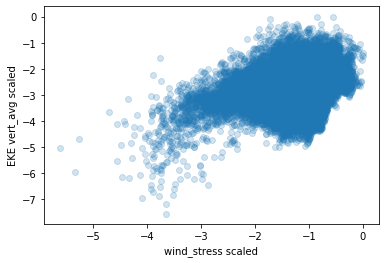

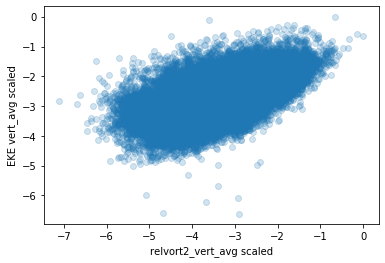

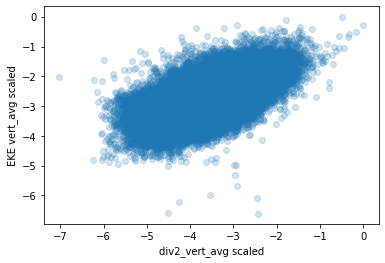

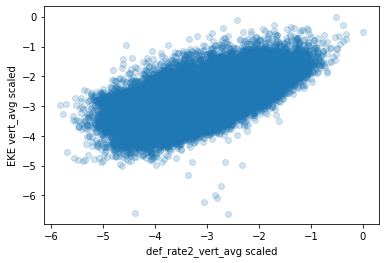

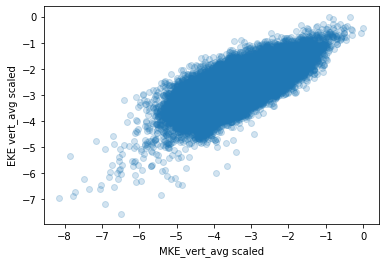

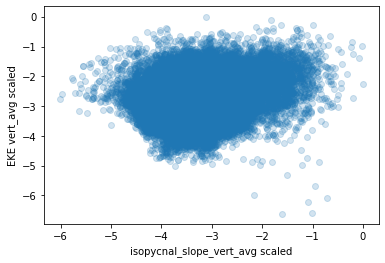

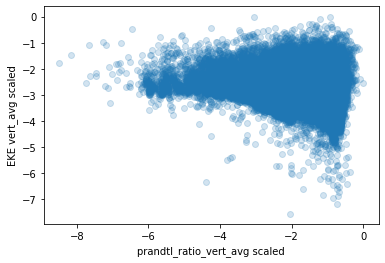

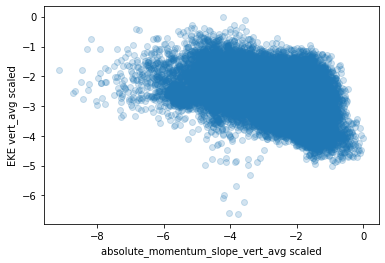

In [8]:
for varidx in range(len(model_data.predictors)):
    plt.figure()
    plt.scatter(np.log10(X_scaled[:,varidx]),np.log10(Y_scaled[:,0]),alpha = 0.2),
    plt.xlabel(f'{list(model_data.predictors)[varidx]} scaled')
    plt.ylabel(f'EKE vert_avg scaled')